Time series data: như là một loại dữ liệu thay đổi theo thời gian. VD: nhiệt độ trong 1 ngày, giá cổ phiếu của 1 công ty trong năm,..
LSTM có khả năng nắm bắt các mẫu trong dữ liệu chuỗi thời gian và do đó có thể được sử dụng để đưa ra dự đoán về xu hướng dữ liệu trong tương lai.


In [0]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
sns.get_dataset_names()

/usr/local/lib/python3.6/dist-packages/seaborn/utils.py:384: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 384 of the file /usr/local/lib/python3.6/dist-packages/seaborn/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'iris',
 'mpg',
 'planets',
 'tips',
 'titanic']

Sử dụng bộ dữ liệu flights trong thư viện Seaborn. Có 144 dòng và 3 cột dữ liệu. Nhiệm vụ là dự đoán số lượng hành khách đã đi trong 12 tháng tiếp theo dựa trên 132 tháng đầu tiên. Như vậy dùng 132 tháng đầu để train model, và đánh giá model bằng 12 tháng cuối.

In [0]:
flight_data = sns.load_dataset("flights")
flight_data.head(10)

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
5,1949,June,135
6,1949,July,148
7,1949,August,148
8,1949,September,136
9,1949,October,119


In [0]:
flight_data.shape

(144, 3)

In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

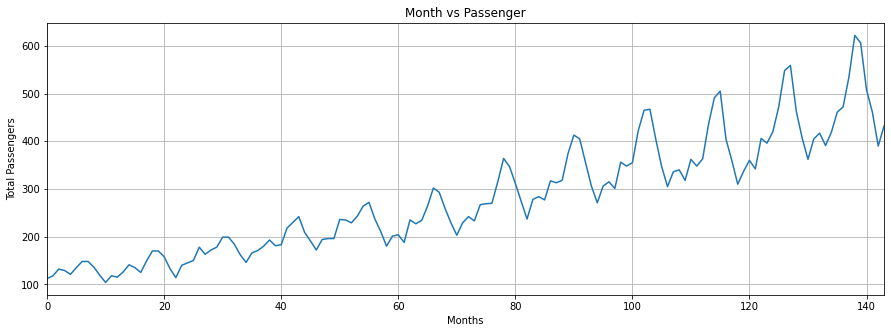

In [0]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [0]:
#Loại của các cột trong tập dữ liệu là object. 
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [0]:
#Bước tiền xử lý đầu tiên thay đổi loại của cột passengers thành float.
print(flight_data['passengers'].values)
all_data = flight_data['passengers'].values.astype(float)

[112 118 132 129 121 135 148 148 136 119 104 118 115 126 141 135 125 149
 170 170 158 133 114 140 145 150 178 163 172 178 199 199 184 162 146 166
 171 180 193 181 183 218 230 242 209 191 172 194 196 196 236 235 229 243
 264 272 237 211 180 201 204 188 235 227 234 264 302 293 259 229 203 229
 242 233 267 269 270 315 364 347 312 274 237 278 284 277 317 313 318 374
 413 405 355 306 271 306 315 301 356 348 355 422 465 467 404 347 305 336
 340 318 362 348 363 435 491 505 404 359 310 337 360 342 406 396 420 472
 548 559 463 407 362 405 417 391 419 461 472 535 622 606 508 461 390 432]


In [0]:
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [0]:
#Chia bộ dữ liệu thành tập train (132) và tập test (12) 
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [0]:
print(len(train_data))
print(len(test_data))

132
12


In [0]:
print(test_data)

[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


In [0]:
#Tổng số hành khách những năm đầu ít hơn nhiều so với những năm sau, chuẩn hóa dữ liệu trong phạm vi -1 và 1.
#Chỉ chuẩn hóa trên tập train, nếu dùng trên tập test có khả năng bị rò rỉ 1 số thông tin từ tập train vào tập test. 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [0]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [0]:
#Bước tiếp theo chuyển đổi data sang dạng  tensor.
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
print(train_data_normalized)

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385, -0.9516, -0.9033, -0.8374, -0.8637,
        -0.9077, -0.8022, -0.7099, -0.7099, -0.7626, -0.8725, -0.9560, -0.8418,
        -0.8198, -0.7978, -0.6747, -0.7407, -0.7011, -0.6747, -0.5824, -0.5824,
        -0.6484, -0.7451, -0.8154, -0.7275, -0.7055, -0.6659, -0.6088, -0.6615,
        -0.6527, -0.4989, -0.4462, -0.3934, -0.5385, -0.6176, -0.7011, -0.6044,
        -0.5956, -0.5956, -0.4198, -0.4242, -0.4505, -0.3890, -0.2967, -0.2615,
        -0.4154, -0.5297, -0.6659, -0.5736, -0.5604, -0.6308, -0.4242, -0.4593,
        -0.4286, -0.2967, -0.1297, -0.1692, -0.3187, -0.4505, -0.5648, -0.4505,
        -0.3934, -0.4330, -0.2835, -0.2747, -0.2703, -0.0725,  0.1429,  0.0681,
        -0.0857, -0.2527, -0.4154, -0.2352, -0.2088, -0.2396, -0.0637, -0.0813,
        -0.0593,  0.1868,  0.3582,  0.3231,  0.1033, -0.1121, -0.2659, -0.1121,
        -0.0725, -0.1341,  0.1077,  0.07

In [0]:
#Bước tiền xử lý cuối cùng là chuyển train data thành các chuỗi và nhãn tương ứng.
#Vì dữ liệu theo hàng tháng nên sử dụng độ dài chuỗi là 12.

train_window = 12

In [0]:
#Định nghĩ hàm create_inout_sequences nhận dữ liệu thô và trả về  1 list of tuples. 
#Mỗi bộ, thành phần đầu tiên chứa 12 item tương ứng số hành khách đi trong 12 tháng, thành phần thứ 2 là chứa 1 item của số lượng hành khách trong tháng tiếp theo 12 tháng đó.
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [0]:
#Tạo chuỗi và nhãn tương ứng cho train data. Nó chứa 120 item, có nghĩa là do train data có 132 item, độ dài chuỗi 12
#Thì chuỗi đầu tiên chứa 12 item đầu và item 13 là label cho chuỗi đầu tiên, tương tự chuỗi thứ 2 bắt đầu từ item thứ 2 đến item thứ 13 và item 14 là label cho chuỗi thứ 2, cứ vậy đến hết.
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [0]:
train_inout_seq[:5]


[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

In [0]:
#Input_size: Tương ứng với số lượng feature trong đầu vào. Mặc dù độ dài chuỗi của là 12, nhưng mỗi tháng chỉ có 1 giá trị tức là tổng số hành khách, do đó kích thước đầu vào sẽ là 1.
#output_size: vì muốn dự đoán số lượng hành khách trong 1 tháng trong tương lai, kích thước đầu ra sẽ là 1.
#Thuật toán LSTM chấp nhận ba đầu vào: previous hidden_cell,  previous cell state và đầu vào hiện tại. Các hidden_cell  chứa các trạng thái ẩn và tế bào trước. Các biến lstm và linear lớp được sử dụng để tạo LSTM và các lớp tuyến tính.
#Bên trong phương thức forward, input_seq được truyền dưới dạng tham số, lần đầu tiên được truyền qua lớp lstm. Đầu ra của lớp lstm là the hidden and cell states ở bước thời gian hiện tại, cùng với đầu ra. Đầu ra từ lớp lstm được truyền cho lớp linear. Số lượng hành khách dự đoán được lưu trữ trong mục cuối cùng của danh sách predictions.
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1): #
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1] #Lấy thằng cuối cùng 

In [0]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [0]:
#test
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1): #
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        print("lstm_out_before--------")
        print(lstm_out.size())
        print(lstm_out)
        predictions = self.linear(lstm_out)
        print("Predictions----------------------")
        print(predictions.size())
        print(predictions)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("Predictions----------------------")
        print(predictions.size())
        print(predictions)
        print("lstm_out----------------------")
        print(lstm_out.size())
        print(lstm_out)
        print("hidden_cell----------------------")
        print(self.hidden_cell)
        return predictions[-1]

In [0]:
 #test
 model = LSTM()
 for seq, labels in train_inout_seq[0:1]:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        print(seq)
        pred = model(seq)


tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])
lstm_out_before--------
torch.Size([12, 1, 100])
tensor([[[ 0.0136,  0.0091, -0.0156,  ..., -0.0231,  0.0145,  0.0378]],

        [[ 0.0222,  0.0137, -0.0259,  ..., -0.0379,  0.0154,  0.0621]],

        [[ 0.0275,  0.0161, -0.0319,  ..., -0.0464,  0.0113,  0.0753]],

        ...,

        [[ 0.0327,  0.0226, -0.0421,  ..., -0.0575, -0.0071,  0.0948]],

        [[ 0.0317,  0.0245, -0.0439,  ..., -0.0583, -0.0077,  0.0980]],

        [[ 0.0318,  0.0247, -0.0441,  ..., -0.0581, -0.0083,  0.0978]]],
       grad_fn=<StackBackward>)
Predictions----------------------
torch.Size([12, 1, 1])
tensor([[[-0.0286]],

        [[-0.0245]],

        [[-0.0214]],

        [[-0.0186]],

        [[-0.0163]],

        [[-0.0152]],

        [[-0.0146]],

        [[-0.0141]],

        [[-0.0133]],

        [[-0.0124]],

        [[-0.0116]],

        [[-0.0118]]], grad_fn=<AddBackward0

In [0]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

Streaming output truncated to the last 5000 lines.
        [ 0.3079],
        [ 0.3175],
        [ 0.4250],
        [ 0.3753],
        [ 0.1890],
        [ 0.1371]], grad_fn=<AddmmBackward>)
tensor([[0.0230],
        [0.1143],
        [0.1043],
        [0.3592],
        [0.3832],
        [0.4244],
        [0.4737],
        [0.5396],
        [0.3908],
        [0.1038],
        [0.0385],
        [0.2641]], grad_fn=<AddmmBackward>)
epoch:  76 loss: 0.00347305
tensor([[-0.7078],
        [-0.7139],
        [-0.6966],
        [-0.7547],
        [-0.8035],
        [-0.7468],
        [-0.6044],
        [-0.4610],
        [-0.5403],
        [-0.7201],
        [-0.7425],
        [-0.7556]], grad_fn=<AddmmBackward>)
tensor([[-0.6914],
        [-0.6712],
        [-0.7170],
        [-0.7774],
        [-0.7691],
        [-0.7228],
        [-0.6090],
        [-0.5100],
        [-0.6279],
        [-0.7492],
        [-0.6883],
        [-0.7894]], grad_fn=<AddmmBackward>)
tensor([[-0.6495],
        [-0.

KeyboardInterrupt: ignored

In [0]:
for seq, labels in train_inout_seq[:2]:
  # print (len(seq))
  # print (seq.size())
  print(seq)
  seq.view(len(seq) ,1, -1)
  print(seq)
  print (seq.size())
  print (seq.type)


# y = torch.tensor([[[[-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
#         -0.8593, -0.9341, -1.0000, -0.9385]]]])
# print(y)
# print(y.shape)



12
torch.Size([12])
tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])
tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])
torch.Size([12])
<built-in method type of Tensor object at 0x7f1edbe0fb40>
12
torch.Size([12])
tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
        -0.9341, -1.0000, -0.9385, -0.9516])
tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
        -0.9341, -1.0000, -0.9385, -0.9516])
torch.Size([12])
<built-in method type of Tensor object at 0x7f1edbe0fbd0>


In [0]:
class LSTM2(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print(predictions[-1])
        print(predictions)
        return predictions[-1]

In [0]:
for seq, labels in train_inout_seq[:1]:
  print(seq)
  model = LSTM2()
  model(seq)

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])
tensor([-0.1019], grad_fn=<SelectBackward>)
tensor([[-0.0791],
        [-0.0897],
        [-0.0942],
        [-0.0968],
        [-0.0987],
        [-0.0991],
        [-0.0988],
        [-0.0988],
        [-0.0995],
        [-0.1007],
        [-0.1020],
        [-0.1019]], grad_fn=<AddmmBackward>)


In [0]:
#Lọc 12 giá trị cuối từ tập train

fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [0]:
#Trong vòng lặp for sẽ dùng 12 giá trị ở trên để dự đoán giá trị thứ 133
#Giá trị dự đoán sẽ được thêm vào ds test_input
#Trong lần lặp 2, 1 lần nữa 12 giá trị cuối sẽ được sử dụng làm đầu vào và đưa ra 1 dự đoán mới, và lại đưa vào ds test_input
#Cuối vòng lặp test_input chứa 24 giá trị, 12 giá trị cuối cùng chính là giá trị dự đoán.
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [0]:
#Do đã chuẩn hóa dữ liệu để train, nên các giá trị dự đoán cũng chuẩn hóa
test_inputs[fut_pred:]

[0.3997810184955597,
 0.8084654808044434,
 1.0614644289016724,
 1.2469247579574585,
 1.3791301250457764,
 1.4569858312606812,
 1.4912620782852173,
 1.5000951290130615,
 1.4961559772491455,
 1.477561116218567,
 1.4433006048202515,
 1.404617428779602]

In [0]:
#Chuyển các giá trị đã chuẩn hóa về thực tế
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[422.45018171]
 [515.42589688]
 [572.98315758]
 [615.17538244]
 [645.25210345]
 [662.96427661]
 [670.76212281]
 [672.77164185]
 [671.87548482]
 [667.64515394]
 [659.8508876 ]
 [651.05046505]]


In [0]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


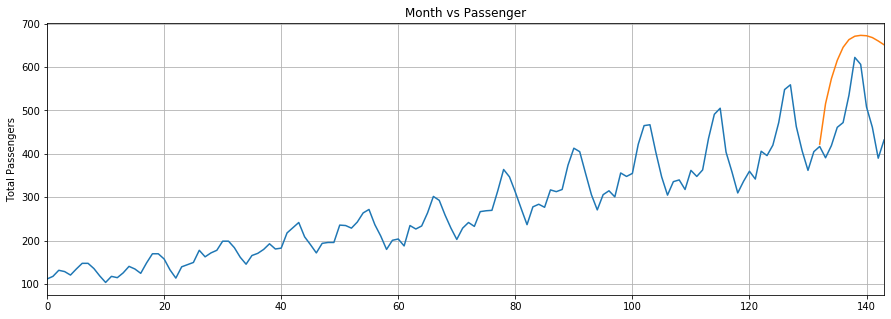

In [0]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

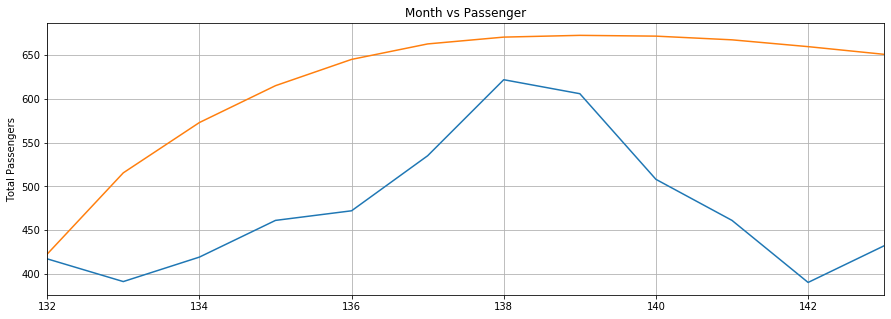

In [0]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

In [0]:
x = torch.randn(3, 4, 2)
z = x.view(-1, 12)
print(x)
print(z)

tensor([[[-1.2754,  1.3643],
         [ 1.4715,  0.3119],
         [-0.0647,  1.6933],
         [-0.7259,  0.6605]],

        [[-0.1287,  0.0146],
         [-1.5691, -0.7520],
         [ 1.2978,  0.4714],
         [-1.3272,  0.4786]],

        [[-0.5141,  0.3718],
         [ 2.1118,  0.2591],
         [ 1.2284, -0.6123],
         [ 0.0856, -1.2629]]])
tensor([[-1.2754,  1.3643,  1.4715,  0.3119, -0.0647,  1.6933, -0.7259,  0.6605,
         -0.1287,  0.0146, -1.5691, -0.7520],
        [ 1.2978,  0.4714, -1.3272,  0.4786, -0.5141,  0.3718,  2.1118,  0.2591,
          1.2284, -0.6123,  0.0856, -1.2629]])
